<a href="https://colab.research.google.com/github/julia-lina-tan/rl-policy-fusion/blob/main/rl_policy_fusion_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook trains agents from Stable Baselines3 in the "Reacher" Gym environment.

1. An agent will be trained to reach for rewards in the 1st quadrant of the workspace
2. An agent will be trained to reach for rewards in the 2nd quadrant of the workspace
3. A fused agent will be initialised from these two previous agents using OT techniques
4. The fused agent will relearn to reach for rewards in both the 1st and 2nd quadrants of the workspace
5. The effectiveness of initialising via fusion (as compared to relearning from the original models or creating a new model from scratch) will be evaluated

# Setup

Install Stable Baselines and other dependencies.

In [ ]:
!pip install stable-baselines3[extra]
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

In [ ]:
# Additional installations/imports for rendering Gym environment

!apt-get install -y xvfb x11-utils
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* 
!apt-get install imagemagick

import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

Install [pybullet-gym](https://github.com/benelot/pybullet-gym) and import Reacher environment.

In [ ]:
!git clone https://github.com/openai/gym.git
!cd gym && pip install -e .

In [ ]:
!git clone https://github.com/benelot/pybullet-gym.git
!cd pybullet-gym && pip install -e . 

Restart local runtime for pybulletgym import to work.

In [1]:
import gym  # open ai gym
import pybulletgym  # register PyBullet enviroments with open ai gym

env = gym.make('ReacherPyBulletEnv-v0')
# env.render() # call this before env.reset, if you want a window showing the environment
env.reset()  # should return a state vector if everything worked

print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (2,), float32)
Box(-inf, inf, (9,), float32)


/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Import RL policy, RL agents and wrappers.

In [5]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

## Rendering agent in environment

In [56]:
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import animation
import pybullet as p

def env_render(env):
    view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0,0,0.05],
                                                      distance=0.7,
                                                      yaw=90,
                                                      pitch=-90,
                                                      roll=0,
                                                      upAxisIndex=2)
    proj_matrix = p.computeProjectionMatrixFOV(fov=60,
                                                  aspect=float(960) /720,
                                                  nearVal=0.1,
                                                  farVal=100.0)
    (_, _, px, _, _) = p.getCameraImage(width=960,
                                          height=720,
                                          viewMatrix=view_matrix,
                                          projectionMatrix=proj_matrix,
                                          renderer=p.ER_BULLET_HARDWARE_OPENGL)

    rgb_array = np.array(px, dtype=np.uint8)
    rgb_array = np.reshape(rgb_array, (720,960, 4))
    rgb_array = rgb_array[:, :, :3]
    return rgb_array

def save_frames_as_gif(frames, path='../content', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

def render_agent_in_env(agent, env, n_eval_episodes=5, path='../content', filename='gym_animation'):
    for i in range(n_eval_episodes):
      frames = []
      obs = env.reset()
      for t in range(500):

          #Render to frames buffer
          frame = env_render(env)
          cv2.putText(frame, text=f'Episode {i+1}', org=(50,50), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.8, color=(0,0,0))
          frames.append(frame)
          action, _states = model.predict(obs)
          obs, rewards, done, info = env.step(action)
          if done:
            break
      save_frames_as_gif(frames, path=path, filename=f'{filename}-ep{i+1}.gif')

# Train agent

In [6]:
env = Monitor(env)
model = PPO('MlpPolicy', env, verbose=1, seed=1)

# TODO: configure the model

model.learn(total_timesteps=1e4)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 150      |
|    ep_rew_mean     | -7.17    |
| time/              |          |
|    fps             | 948      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 150          |
|    ep_rew_mean          | -11.3        |
| time/                   |              |
|    fps                  | 749          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0017198424 |
|    clip_fraction        | 0.0218       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    e

## Extracting policy from model parameters

In [7]:
model_params = model.get_parameters()

def get_policy(model_params, net='action'):
    """
    Get either action or value net representing the actor-critic policy.

    :param model_params: (dict) the model parameters
    :param net: (str) the net type to return; either ``action`` or ``value``
    """
    if net != 'action' and net != 'value':
        raise ValueError('Must be either action net or value net')
    return model_params.get('policy').get(net+'_net.weight')

action_net = get_policy(model_params, net='action')
print(action_net)

tensor([[ 1.2175e-02,  1.6273e-02, -3.9786e-03,  8.0242e-03, -8.7277e-03,
         -1.6253e-02, -7.8787e-04, -8.0563e-03,  1.8014e-02, -6.4047e-04,
          4.4614e-03,  7.5539e-03,  1.6027e-03,  1.4935e-02,  6.2752e-04,
          6.3743e-03, -5.8755e-03, -6.8140e-03,  5.1002e-03,  3.7435e-03,
          7.7626e-03, -2.7319e-03,  1.1279e-02, -1.0988e-03,  8.4333e-03,
          3.3157e-04,  3.2371e-03,  3.1546e-03,  1.3872e-02, -1.1493e-02,
         -6.1277e-03,  8.4890e-03, -9.9812e-03, -1.8781e-02,  5.3402e-03,
         -2.7289e-02,  6.0635e-03,  4.8187e-03,  1.1292e-02, -1.2810e-02,
         -1.3313e-02, -1.2751e-02,  6.7584e-03,  1.1093e-02, -1.2120e-02,
          2.7913e-03, -4.3908e-03,  4.8392e-03, -1.5131e-02,  1.9965e-03,
         -6.3712e-03, -3.0887e-05,  1.0601e-03,  2.3472e-02,  5.9054e-04,
         -1.0021e-02, -5.2373e-03, -8.0585e-03,  2.2529e-02,  6.5239e-03,
          2.0902e-02,  7.8419e-03,  1.8021e-02, -1.6167e-02],
        [-1.4487e-02,  3.5976e-03,  1.4010e-02, -8

# Test agent

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy

def plot_rewards(mean_reward, title=None):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards at episode')
    plt.xticks(list(range(1, len(mean_reward)+1)))
    plt.plot(list(range(1, len(mean_reward)+1)), mean_reward, marker='o')
    plt.show()

mean reward=-5.08 +/- 8.88


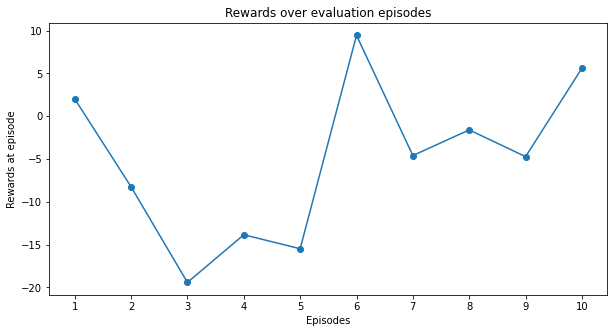

In [9]:
ep_rewards, ep_steps = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

Visualise the performance of the agent over a number of evaluation episodes.

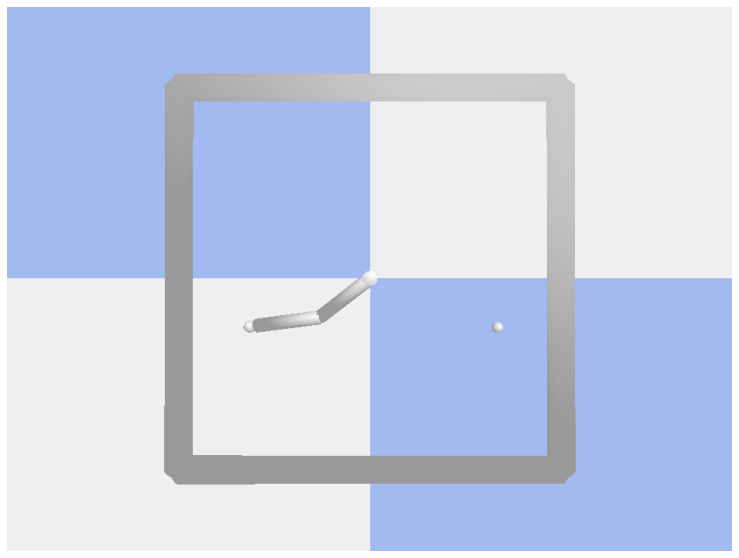

In [57]:
import os

os.makedirs('../content/agent1', exist_ok=True)
render_agent_in_env(model, env, n_eval_episodes=1, path='../content/agent1', filename='test')